Andrew Dodd
, 2/21/18
# Machine Learning Project Notebook
## Table of Contents
### 1. Imports
### 2. Cleaning
### 3. Exploration/Unsupervised Learning
### 4. Modeling
### 5. Ensembling
### 6. Write to csv (results, data)

## 1. Imports

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline

house_train = pd.read_csv('./data/train.csv')
house_test = pd.read_csv('./data/test.csv')

house_train.rename(index=str, columns={"BedroomAbvGr":"Bedroom", "KitchenAbvGr":"Kitchen"},
                   inplace = True)
house_test.rename(index=str, columns={"BedroomAbvGr":"Bedroom", "KitchenAbvGr":"Kitchen"},
                    inplace = True)

names = list(house_test.columns.values)

In [35]:
house_train.shape
house_test.shape

(1459, 80)

## 2. Cleaning
Here we do the cleaning for the data. This will include examining the dataset, value imputation, visualization, filling or removing NAs, etc.

### 2.1 Converting column types to numeric
Now that we have our dataset imported, we need to convert the numeric parts into numeric.

In [36]:
with open("./Data/data_description.txt") as f:
    content = f.readlines()
    
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content] 

import re

prev_column = '' # Most recent column name
num_lines = 0 # number of lines since column name
i = 0
for line in content:
    if (re.search('^(.{1,20}):.*', line) != None) and (num_lines == 1):
        house_train[prev_column] = pd.to_numeric(house_train[prev_column],errors = 'coerce')
        house_test[prev_column] = pd.to_numeric(house_test[prev_column],errors = 'coerce')
    if line.strip() == '':
        num_lines += 1
        next
    if (re.search('^(.{1,20}):.*', line) != None):
        prev_column = (re.search('^(.{1,20}):.*', line)).group(1)
        num_lines = 0
    i += 1

In [37]:
# Showing some interesting values...
house_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [38]:
# house_train.columns.to_series().groupby(house_train.dtypes).groups

In [39]:
house_train.shape

(1460, 81)

### 2.2 Converting strings to factors and fixing values

Here we will figure out which train and test columns have values that are not a subset of the text file. In some cases, I will adjust these values.

In [40]:
prev_column = '' # Most recent column name
i = 0      # Number of loop iterations
flag = 0   # This is an indicator of whether we want to be parsing column categories
           # 0 corresponds to no, 1 corresponds to yes
           # It is set to 1 once we pass a blank row.
start = 0  # This is the number of column categories we have iterated through so far

# MAKE A DICTIONARY HERE
all_col_categ = {}
one_category_list = []
category_counter = 0
columnName = ''

# Iterating through entire list of column names and their categories.
for line in content:
    # print("-"*60)
    # print("line number:  %d" %i)
    
    # Check if it's not a new column name, flag is 1, and line is not blank
    # Let's get a list of the data
    if (re.search('^(.{1,20}):.*', line) == None) and (flag == 1) and line.strip() != '':
        # Using regex, second match is what we want:
        category = re.search('^[ |\t]*?([A-Za-z0-9_-]*)[ |\t]*(.{1,50})?',line).group(1)
        one_category_list.append(category)
        category_counter += 1
        
    # Here we check if this is the blank line after all the category names of a column.
    # It checks that our flag is 1 and that we have a blank line.
    if (flag == 1) and line.strip() == '':
        all_col_categ[columnName]=one_category_list
        #all_col_categ.append(one_category_list)
        
    # Adding to the flag
    if line.strip() == '':
        flag += 1
        
    # Reset our flag to zero when we get to a new name
    if (re.search('^(.{1,20}):.*', line) != None):
        prev_column = (re.search('^(.{1,20}):.*', line)).group(1)
        one_category_list = []   # reset our category list to null
        columnName = re.search('^(.{1,20}):.*', line).group(1)
        flag = 0             # reset our flag to 0
        category_counter = 0 # reset our category counter
        
    i += 1
#Missed last category set:
last_categories = ['Normal','Abnormal','AdjLand','Alloca','Family','Partial']
all_col_categ['SaleCondition'] = last_categories

#print(all_col_categ)

In [41]:
house_train.shape

(1460, 81)

Here we will go through all of the columns. In each column, we check if it is numeric. If it is not, we will compare the category options in the text file to the categories in the dataset. If they do not match, we print the column name.

In [60]:
# Our two lists of column names are not in order together

import numbers
j = 0
for i in range(len(names)):
    name = names[i]
    
    # If the column is not numeric, we will check the categories
    if isinstance(house_train[name][0], numbers.Number) == 0:  
#         print(i)
#         print('-'*100)
#         print(name)
        all_col_set = set(all_col_categ[name])   # set of all ~42 categories from columns.txt

        # Check if sets are equal for train and test set. If they are not, print them.
        
        train_col = house_train.iloc[:, [i]]
        set_unique_train = set(pd.unique(train_col.values.ravel()))
        test_col = house_test.iloc[:, [i]]
        set_unique_test = set(pd.unique(test_col.values.ravel()))
        
#         if set_unique_train.issubset(all_col_set)==0 or set_unique_test.issubset(all_col_set)==0:
#             print(all_col_set)
#             print('.'*50)
        
#         if set_unique_train.issubset(all_col_set)==0:
#             print("The train unique values are not contained in the set from columns.txt")
#             print(set_unique_train)
#             print('.'*50)
        
#         if set_unique_test.issubset(all_col_set)==0:
#             print("The test unique values are not contained in the set from columns.txt")
#             print(set_unique_test)
            
        #CHECK TEST TOO
        
        j += 1


In [43]:
house_train.shape

(1460, 81)

Fixing misnamed values

In [44]:
# MSZoning
mask = house_train.MSZoning == 'C (all)'
house_train.loc[mask, 'MSZoning'] = 'C'

# Utilities
# Interesting that the Utilities training set are all included, but test only has AllPub and nan...

# Neighborhood
mask = house_train.Neighborhood == 'NAmes'
house_train.loc[mask, 'Neighborhood'] = 'Names'
mask = house_test.Neighborhood == 'NAmes'
house_test.loc[mask, 'Neighborhood'] = 'Names'

# Building type: ignoring because the train and test match.

# House style - looks fine.
# Interestingly, 2.5 Fin is in only the training set, does not appear in test set.

# RoofMat1
# Train haas 4 more categories than test. Train has ClyTile, Metal, Membran, and Roll, which test does not have.

# Exterior1st
# Train has stone and ImStucc (test does not have these.)
# Test does not have ImStucc at all. Also has nan.
# Maybe we want to change ImStucc in to Stucc in train set?

# Exterior2nd
# nan is included in test, but not in train

# MasVnrType
# No Cblock, but we do have nans

# I did not write all the mismatched columns. The above is about half of them.
# I don't think we need to change any of the values to something else at this moment. 
# Next we'll look at nans.b

In [45]:
house_train.shape

(1460, 81)

### 2.3  Fixing all the NaNs

In [46]:
########################################## TRAIN #######################################
mask = house_train.Alley.isnull()
house_train.loc[mask, 'Alley'] = 'No'

mask = house_train.PoolQC.isnull()
house_train.loc[mask, 'PoolQC'] = 'No'

mask = house_train.FireplaceQu.isnull()
house_train.loc[mask, 'FireplaceQu'] = 'No'

mask = house_train.Fence.isnull()
house_train.loc[mask, 'Fence'] = 'No'

mask = house_train.MiscFeature.isnull()
house_train.loc[mask, 'MiscFeature'] = 'No'

# Garage
mask = house_train.GarageType.isnull()
house_train.loc[mask, 'GarageType'] = 'No'

mask = house_train.GarageFinish.isnull()
house_train.loc[mask, 'GarageFinish'] = 'No'

mask = house_train.GarageCond.isnull()
house_train.loc[mask, 'GarageCond'] = 'No'

mask = house_train.GarageQual.isnull()
house_train.loc[mask, 'GarageQual'] = 'No'

# Basement
mask = house_train.BsmtQual.isnull()
house_train.loc[mask, 'BsmtQual'] = 'No'

mask = house_train.BsmtCond.isnull()
house_train.loc[mask, 'BsmtCond'] = 'No'

#mask = house_train.BsmtExposure.isnull()
#house_train.loc[mask, 'BsmtExposure'] = 'No'

mask = house_train.BsmtFinType1.isnull()
house_train.loc[mask, 'BsmtFinType1'] = 'No'

mask = house_train.BsmtFinType2.isnull()
house_train.loc[mask, 'BsmtFinType2'] = 'No'

# Other
mask = house_train.MasVnrType.isnull()
house_train.loc[mask, 'MasVnrType'] = 'No'

mask = house_train.MasVnrArea.isnull()
house_train.loc[mask, 'MasVnrArea'] = 0



########################################## TEST #######################################
mask = house_test.Alley.isnull()
house_test.loc[mask, 'Alley'] = 'No'

mask = house_test.PoolQC.isnull()
house_test.loc[mask, 'PoolQC'] = 'No'

mask = house_test.FireplaceQu.isnull()
house_test.loc[mask, 'FireplaceQu'] = 'No'

mask = house_test.Fence.isnull()
house_test.loc[mask, 'Fence'] = 'No'

mask = house_test.MiscFeature.isnull()
house_test.loc[mask, 'MiscFeature'] = 'No'

# Garage
mask = house_test.GarageType.isnull()
house_test.loc[mask, 'GarageType'] = 'No'

mask = house_test.GarageFinish.isnull()
house_test.loc[mask, 'GarageFinish'] = 'No'

mask = house_test.GarageCond.isnull()
house_test.loc[mask, 'GarageCond'] = 'No'

mask = house_test.GarageQual.isnull()
house_test.loc[mask, 'GarageQual'] = 'No'

# Basement
mask = house_test.BsmtQual.isnull()
house_test.loc[mask, 'BsmtQual'] = 'No'

mask = house_test.BsmtCond.isnull()
house_test.loc[mask, 'BsmtCond'] = 'No'

#mask = house_test.BsmtExposure.isnull()
#house_test.loc[mask, 'BsmtExposure'] = 'No'

mask = house_test.BsmtFinType1.isnull()
house_test.loc[mask, 'BsmtFinType1'] = 'No'

mask = house_test.BsmtFinType2.isnull()
house_test.loc[mask, 'BsmtFinType2'] = 'No'

# Other
mask = house_test.MasVnrType.isnull()
house_test.loc[mask, 'MasVnrType'] = 'No'

mask = house_test.MasVnrArea.isnull()
house_test.loc[mask, 'MasVnrArea'] = 0

In [47]:
house_train.shape

(1460, 81)

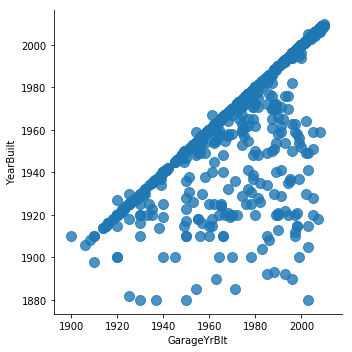

In [48]:
# Examining year built and garage, maybe we should have our GarageYrBlt nans be YearBuilt? 
# Perhaps this is not true though...
sns.lmplot('GarageYrBlt', # Horizontal axis
           'YearBuilt', # Vertical axis
           data=house_train, # Data source
           fit_reg=False, # Don't fix a regression line
           #hue="z", # Set color
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100}) # S marker size

# I think it is fair to say this...it probably just means that there is no garage...
mask = house_test.GarageYrBlt.isnull()
house_test.loc[mask, 'GarageYrBlt'] = house_test.YearBuilt

mask = house_train.GarageYrBlt.isnull()
house_train.loc[mask, 'GarageYrBlt'] = house_train.YearBuilt


Filling in the last remaining NaNs with KNN:
 * Lot Frontage (~300)
 * Electrical (1)
 * 

In [50]:
house_train.shape

(1460, 81)

In [51]:
# from fancyimpute import KNN 

# house_train = KNN(k=20).complete(house_train)
# house_test = KNN(k=20).complete(house_test)

# Filling in the numeric with the median value.
# here we impute the median of a bunch of 1 nans (number of basement bathrooms)
# The larger imputation here for error causing is lot frontage, with around ~300 imputations.
house_train.fillna(house_train.median(),inplace = True)
house_test.fillna(house_test.median(),inplace = True)

# Filling in the categoricals with the median value.
house_train = house_train.apply(lambda x:x.fillna(x.value_counts().index[0]))
house_test = house_test.apply(lambda x:x.fillna(x.value_counts().index[0]))

# Test
for i in range(len(names)):
    s = house_test.iloc[:,i]
    sum1 = s.isnull().sum()
    if sum1 != 0:
        print(names[i])
        print(sum1)

# Train
for i in range(len(names)):
    s = house_train.iloc[:,i]
    sum1 = s.isnull().sum()
    if sum1 != 0:
        print(names[i])
        print(sum1)
        
# Nothing printed means no more NAs! Now we can do other stuff!

In [52]:
house_train.shape

(1460, 81)

In [53]:
house_train.to_csv("train_0N.csv")
house_test.to_csv("test_0N.csv")

### 2.3 Converting ordinal categories into numeric.

Here we will convert the following columns from categorical to numeric:
* GarageQual
* GarageCond
* FireplaceQu
* KitchenQual
* HeatingQC
* BsmtCond
* BsmtQual
* ExterCond
* ExterQual

In [54]:
train_col = house_train.iloc[:, [28]]
set_unique_train = set(pd.unique(train_col.values.ravel()))
print(set_unique_train)
print(names[28])

{'Gd', 'TA', 'Po', 'Fa', 'Ex'}
ExterCond


In [55]:
#########################################
# TRAIN
#########################################

qual_dict = {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5,
            0:0, 1:1, 2:2, 3:3, 4:4, 5:5}
house_train["ExterQual"] = house_train["ExterQual"].map(qual_dict).astype(int)
house_train["ExterCond"] = house_train["ExterCond"].map(qual_dict).astype(int)
house_train["BsmtQual"] = house_train["BsmtQual"].map(qual_dict).astype(int)
house_train["BsmtCond"] = house_train["BsmtCond"].map(qual_dict).astype(int)
house_train["HeatingQC"] = house_train["HeatingQC"].map(qual_dict).astype(int)
house_train["KitchenQual"] = house_train["KitchenQual"].map(qual_dict).astype(int)
house_train["FireplaceQu"] = house_train["FireplaceQu"].map(qual_dict).astype(int)
house_train["GarageQual"] = house_train["GarageQual"].map(qual_dict).astype(int)
house_train["GarageCond"] = house_train["GarageCond"].map(qual_dict).astype(int)

#########################################
# TEST
#########################################

qual_dict = {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5,
            0:0, 1:1, 2:2, 3:3, 4:4, 5:5}
house_test["ExterQual"] = house_test["ExterQual"].map(qual_dict).astype(int)
house_test["ExterCond"] = house_test["ExterCond"].map(qual_dict).astype(int)
house_test["BsmtQual"] = house_test["BsmtQual"].map(qual_dict).astype(int)
house_test["BsmtCond"] = house_test["BsmtCond"].map(qual_dict).astype(int)
house_test["HeatingQC"] = house_test["HeatingQC"].map(qual_dict).astype(int)
house_test["KitchenQual"] = house_test["KitchenQual"].map(qual_dict).astype(int)
house_test["FireplaceQu"] = house_test["FireplaceQu"].map(qual_dict).astype(int)
house_test["GarageQual"] = house_test["GarageQual"].map(qual_dict).astype(int)
house_test["GarageCond"] = house_test["GarageCond"].map(qual_dict).astype(int)

In [56]:
house_train.shape

(1460, 81)

In [57]:
#########################################
# TRAIN
#########################################

house_train["BsmtExposure"] = house_train["BsmtExposure"].map({None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4,
                                                              0:0, 1:1, 2:2, 3:3, 4:4}).astype(int)

bsmt_fin_dict = {"No": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6,
                0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6}
house_train["BsmtFinType1"] = house_train["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
house_train["BsmtFinType2"] = house_train["BsmtFinType2"].map(bsmt_fin_dict).astype(int)

house_train["Functional"] = house_train["Functional"].map(
        {"No": 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8, 
          0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8}).astype(int)

house_train["GarageFinish"] = house_train["GarageFinish"].map(
        {"No": 0, "Unf": 1, "RFn": 2, "Fin": 3, 0:0, 1:1, 2:2, 3:3}).astype(int)

house_train["Fence"] = house_train["Fence"].map(
        {"No": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4,
         0:0, 1:1, 2:2, 3:3, 4:4}).astype(int)

house_train["CentralAir"] = house_train["CentralAir"].map(
        {"N": 0, "Y": 1,
         0:0, 1:1}).astype(int)

#########################################
# TEST
#########################################

house_test["BsmtExposure"] = house_test["BsmtExposure"].map({None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4,
                                                              0:0, 1:1, 2:2, 3:3, 4:4}).astype(int)

bsmt_fin_dict = {"No": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6,
                0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6}
house_test["BsmtFinType1"] = house_test["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
house_test["BsmtFinType2"] = house_test["BsmtFinType2"].map(bsmt_fin_dict).astype(int)

house_test["Functional"] = house_test["Functional"].map(
        {"No": 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8, 
          0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8}).astype(int)

house_test["GarageFinish"] = house_test["GarageFinish"].map(
        {"No": 0, "Unf": 1, "RFn": 2, "Fin": 3, 0:0, 1:1, 2:2, 3:3}).astype(int)

house_test["Fence"] = house_test["Fence"].map(
        {"No": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4,
         0:0, 1:1, 2:2, 3:3, 4:4}).astype(int)

house_test["CentralAir"] = house_test["CentralAir"].map(
        {"N": 0, "Y": 1,
         0:0, 1:1}).astype(int)

In [58]:
house_train.shape

(1460, 81)

In [59]:
x = house_train.columns.to_series().groupby(house_train.dtypes).groups
print(x)

{dtype('int64'): Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Bedroom',
       'Kitchen', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'Fence', 'MiscVal', 'MoSold', 'YrSold',
       'SalePrice'],
      dtype='object'), dtype('float64'): Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object'), dtype('O'): Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig'

### 2.4 Non-ordinal Categorical Variables and Feature Engineering

In [29]:
#########################################
# TRAIN
#########################################

# IR2 and IR3 don't appear that often, so just make a distinction
# between regular and irregular.
house_train["IsRegularLotShape"] = (house_train["LotShape"] == "Reg") * 1

# Most properties are level; bin the other possibilities together
# as "not level".
house_train["IsLandLevel"] = (house_train["LandContour"] == "Lvl") * 1

# Most land slopes are gentle; treat the others as "not gentle".
house_train["IsLandSlopeGentle"] = (house_train["LandSlope"] == "Gtl") * 1

# Most properties use standard circuit breakers.
house_train["IsElectricalSBrkr"] = (house_train["Electrical"] == "SBrkr") * 1

# About 2/3rd have an attached garage.
house_train["IsGarageDetached"] = (house_train["GarageType"] == "Detchd") * 1

# Most have a paved drive. Treat dirt/gravel and partial pavement
# as "not paved".
house_train["IsPavedDrive"] = (house_train["PavedDrive"] == "Y") * 1

# The only interesting "misc. feature" is the presence of a shed.
house_train["HasShed"] = (house_train["MiscFeature"] == "Shed") * 1.  

# If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
house_train["Remodeled"] = (house_train["YearRemodAdd"] != house_train["YearBuilt"]) * 1
    
# Did a remodeling happen in the year the house was sold?
house_train["RecentRemodel"] = (house_train["YearRemodAdd"] == house_train["YrSold"]) * 1
    
# Was this house sold in the year it was built?
house_train["VeryNewHouse"] = (house_train["YearBuilt"] == house_train["YrSold"]) * 1

#########################################
# TEST
#########################################

# IR2 and IR3 don't appear that often, so just make a distinction
# between regular and irregular.
house_test["IsRegularLotShape"] = (house_test["LotShape"] == "Reg") * 1

# Most properties are level; bin the other possibilities together
# as "not level".
house_test["IsLandLevel"] = (house_test["LandContour"] == "Lvl") * 1

# Most land slopes are gentle; treat the others as "not gentle".
house_test["IsLandSlopeGentle"] = (house_test["LandSlope"] == "Gtl") * 1

# Most properties use standard circuit breakers.
house_test["IsElectricalSBrkr"] = (house_test["Electrical"] == "SBrkr") * 1

# About 2/3rd have an attached garage.
house_test["IsGarageDetached"] = (house_test["GarageType"] == "Detchd") * 1

# Most have a paved drive. Treat dirt/gravel and partial pavement
# as "not paved".
house_test["IsPavedDrive"] = (house_test["PavedDrive"] == "Y") * 1

# The only interesting "misc. feature" is the presence of a shed.
house_test["HasShed"] = (house_test["MiscFeature"] == "Shed") * 1.  

# If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
house_test["Remodeled"] = (house_test["YearRemodAdd"] != house_test["YearBuilt"]) * 1
    
# Did a remodeling happen in the year the house was sold?
house_test["RecentRemodel"] = (house_test["YearRemodAdd"] == house_test["YrSold"]) * 1
    
# Was this house sold in the year it was built?
house_test["VeryNewHouse"] = (house_test["YearBuilt"] == house_test["YrSold"]) * 1

More feature engineering, a lot of it coming from:
https://www.kaggle.com/humananalog/xgboost-lasso/code

In [16]:
# More feature engineering...

#########################################
# TRAIN
#########################################

house_train["Has2ndFloor"] = (house_train["2ndFlrSF"] == 0) * 1
house_train["HasMasVnr"] = (house_train["MasVnrArea"] == 0) * 1
house_train["HasWoodDeck"] = (house_train["WoodDeckSF"] == 0) * 1
house_train["HasOpenPorch"] = (house_train["OpenPorchSF"] == 0) * 1
house_train["HasEnclosedPorch"] = (house_train["EnclosedPorch"] == 0) * 1
house_train["Has3SsnPorch"] = (house_train["3SsnPorch"] == 0) * 1
house_train["HasScreenPorch"] = (house_train["ScreenPorch"] == 0) * 1

# Months with the largest number of deals may be significant.
house_train["HighSeason"] = house_train["MoSold"].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

house_train["NewerDwelling"] = house_train["MSSubClass"].replace(
        {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
         90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})   
    
house_train.loc[house_train.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
house_train.loc[house_train.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
house_train.loc[house_train.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
house_train.loc[house_train.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
house_train.loc[house_train.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
house_train["Neighborhood_Good"].fillna(0, inplace=True)

house_train["SaleCondition_PriceDown"] = house_train.SaleCondition.replace(
        {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

# House completed before sale or not
house_train["BoughtOffPlan"] = house_train.SaleCondition.replace(
        {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
    
house_train["BadHeating"] = house_train.HeatingQC.replace(
        {5: 0, 4: 0, 3: 0, 2: 1, 1: 1, 0:0})

area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
house_train["TotalArea"] = house_train[area_cols].sum(axis=1)

house_train["TotalArea1st2nd"] = house_train["1stFlrSF"] + house_train["2ndFlrSF"]

house_train["Age"] = 2010 - house_train["YearBuilt"]
house_train["TimeSinceSold"] = 2010 - house_train["YrSold"]

house_train["SeasonSold"] = house_train["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                                  6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
    
house_train["YearsSinceRemodel"] = house_train["YrSold"] - house_train["YearRemodAdd"]

#########################################
# TEST
#########################################

house_test["Has2ndFloor"] = (house_test["2ndFlrSF"] == 0) * 1
house_test["HasMasVnr"] = (house_test["MasVnrArea"] == 0) * 1
house_test["HasWoodDeck"] = (house_test["WoodDeckSF"] == 0) * 1
house_test["HasOpenPorch"] = (house_test["OpenPorchSF"] == 0) * 1
house_test["HasEnclosedPorch"] = (house_test["EnclosedPorch"] == 0) * 1
house_test["Has3SsnPorch"] = (house_test["3SsnPorch"] == 0) * 1
house_test["HasScreenPorch"] = (house_test["ScreenPorch"] == 0) * 1

# Months with the largest number of deals may be significant.
house_test["HighSeason"] = house_test["MoSold"].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

house_test["NewerDwelling"] = house_test["MSSubClass"].replace(
        {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
         90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})   
    
house_test.loc[house_test.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
house_test.loc[house_test.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
house_test.loc[house_test.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
house_test.loc[house_test.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
house_test.loc[house_test.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
house_test["Neighborhood_Good"].fillna(0, inplace=True)

house_test["SaleCondition_PriceDown"] = house_test.SaleCondition.replace(
        {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

# House completed before sale or not
house_test["BoughtOffPlan"] = house_test.SaleCondition.replace(
        {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
    
house_test["BadHeating"] = house_test.HeatingQC.replace(
        {5: 0, 4: 0, 3: 0, 2: 1, 1: 1, 0:0})

area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
house_test["TotalArea"] = house_test[area_cols].sum(axis=1)

house_test["TotalArea1st2nd"] = house_test["1stFlrSF"] + house_test["2ndFlrSF"]

house_test["Age"] = 2010 - house_test["YearBuilt"]
house_test["TimeSinceSold"] = 2010 - house_test["YrSold"]

house_test["SeasonSold"] = house_test["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                                  6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
    
house_test["YearsSinceRemodel"] = house_test["YrSold"] - house_test["YearRemodAdd"]

Now we add in some neighborhood information:

In [17]:

    
# Bin by neighborhood (a little arbitrarily). Values were computed by: 
# train_df["SalePrice"].groupby(train_df["Neighborhood"]).median().sort_values()
neighborhood_map = {
        "MeadowV" : 0,  #  88000
        "IDOTRR" : 1,   # 103000
        "BrDale" : 1,   # 106000
        "OldTown" : 1,  # 119000
        "Edwards" : 1,  # 119500
        "BrkSide" : 1,  # 124300
        "Sawyer" : 1,   # 135000
        "Blueste" : 1,  # 137500
        "SWISU" : 2,    # 139500
        "Names" : 2,    # 140000
        "NPkVill" : 2,  # 146000
        "Mitchel" : 2,  # 153500
        "SawyerW" : 2,  # 179900
        "Gilbert" : 2,  # 181000
        "NWAmes" : 2,   # 182900
        "Blmngtn" : 2,  # 191000
        "CollgCr" : 2,  # 197200
        "ClearCr" : 3,  # 200250
        "Crawfor" : 3,  # 200624
        "Veenker" : 3,  # 218000
        "Somerst" : 3,  # 225500
        "Timber" : 3,   # 228475
        "StoneBr" : 4,  # 278000
        "NoRidge" : 4,  # 290000
        "NridgHt" : 4,  # 315000
}

house_train["NeighborhoodBin"] = house_train["Neighborhood"].map(neighborhood_map)
house_test["NeighborhoodBin"] = house_test["Neighborhood"].map(neighborhood_map)

Let's see if the USA market housing fluxuations affected this small town. We can put all the points on a plot...

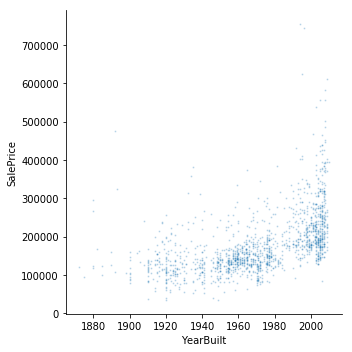

In [18]:
sns.lmplot('YearBuilt', # Horizontal axis
           'SalePrice', # Vertical axis
           data=house_train, # Data source
           fit_reg=False, # Don't fix a regression line
           scatter_kws={"marker": "D", # Set marker style
                        "alpha": .2,
                        "s": 1}) # S marker size

# There is a definite trend here in price, but this might be learned from the year columns...

In [19]:
# house_train.columns.to_series().groupby(house_train.dtypes).groups

Now we have done some good feature engineering. For the rest of the categorical features that are left, we can either omit them or use them as one hot features (get_dummies). We'll see what's best in the future.

### 2.5 Removing Outliers

In order to refine our algorithm we are going to want to remove outliers, points that are too far beyond the realm of likelihood...

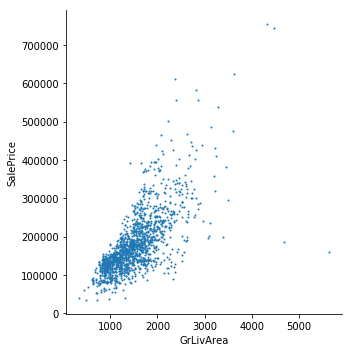

In [20]:
sns.lmplot('GrLivArea', # Horizontal axis
           'SalePrice', # Vertical axis
           data=house_train, # Data source
           fit_reg=False, # Don't fix a regression line
           scatter_kws={"marker": "D", # Set marker style
                        "alpha": 1,
                        "s": 1}) # S marker size

In [21]:
# Based on the author's paper, we will remove some of the outliers:
house_train = house_train.drop(house_train[(house_train.GrLivArea > 4000) & (house_train['SalePrice']<300000)].index)

## 3.0 Exploration, Unsupervised Learning

Now we want to look for some more structure in the data. Are there discernible groups? What features are the primary drivers of SalePrice?

First we will make some dummies for the categorical features so we can do PCA. 

In [22]:
full_df = pd.concat(( house_train, house_test ))
full_df_dummies  = pd.get_dummies(full_df)

house_train_d = full_df_dummies[0:1456]
house_test_d = full_df_dummies[1456:2915]

# Fixing some column names:
house_train_d.rename(index=str, columns={"Exterior1st_Wd Sdng": "Exterior1st_Wd_Sdng", 
                              "HouseStyle_1.5Fin": "HouseStyle_1_5Fin",
                             "HouseStyle_1.5Unf": "HouseStyle_1_5Unf",
                             "HouseStyle_2.5Fin": "HouseStyle_2_5Fin",
                             "HouseStyle_2.5Unf": "HouseStyle_2_5Unf",
                             "Exterior2nd_Brk Cmn": "Exterior2nd_Brk_Cmn",
                             "Exterior2nd_Wd Sdng":"Exterior2nd_Wd_Sdng",
                             "RoofMatl_Tar&Grv":"RoofMatl_Tar_Grv"}, inplace = True)
house_test_d.rename(index=str, columns={"Exterior1st_Wd Sdng": "Exterior1st_Wd_Sdng", 
                              "HouseStyle_1.5Fin": "HouseStyle_1_5Fin",
                             "HouseStyle_1.5Unf": "HouseStyle_1_5Unf",
                             "HouseStyle_2.5Fin": "HouseStyle_2_5Fin",
                             "HouseStyle_2.5Unf": "HouseStyle_2_5Unf",
                              "Exterior2nd_Brk Cmn": "Exterior2nd_Brk_Cmn",
                              "Exterior2nd_Wd Sdng":"Exterior2nd_Wd_Sdng",
                              "RoofMatl_Tar&Grv":"RoofMatl_Tar_Grv"}, inplace = True)
house_train_d.drop(["MSZoning_C (all)","Exterior2nd_Wd Shng"], axis=1, inplace = True)
house_test_d.drop(["MSZoning_C (all)","Exterior2nd_Wd Shng"], axis=1, inplace = True)

/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
house_test_d.drop(['SalePrice'], axis=1, inplace = True)

# Putting SalePrice last, check that the columns are in same order...
names = list(house_train_d.columns.values)
cols = house_train_d.columns.tolist()
cols = cols[0:70] + cols[71:269] + [cols[70]]
house_train_d = house_train_d[cols] 

# Sanity Check
print(house_train.shape)
print(house_test.shape)
print(house_train_d.shape)
print(house_test_d.shape)

(1458, 111)
(1459, 110)
(1456, 266)
(1459, 265)


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
pca = PCA(n_components=5)
pca.fit(house_train_d)
pca.components_ 

array([[ 2.95676560e-03,  1.74760579e-03,  1.64337881e-05, ...,
         4.65812990e-09, -4.65812990e-09,  9.97890246e-01],
       [ 3.27658539e-03, -1.40324160e-03,  2.23754170e-05, ...,
        -3.07934481e-08,  3.07934481e-08, -6.28951572e-02],
       [ 1.71252876e-01,  1.48955916e-01,  3.32225170e-04, ...,
        -3.91610482e-07,  3.91610482e-07, -1.52808338e-02],
       [ 3.18277853e-01, -6.18805380e-01,  1.88472687e-03, ...,
        -4.02002741e-07,  4.02002741e-07, -2.05877187e-03],
       [ 1.54197218e-02,  1.03820271e-01, -2.24717408e-04, ...,
        -5.41576366e-08,  5.41576366e-08, -4.01316613e-03]])

In [27]:
X = house_train_d.ix[:,0:265].values
y = house_train_d.ix[:,265].values

X_std = StandardScaler().fit_transform(X)

In [28]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# print('Eigenvectors \n%s' %eig_vecs)
# print('\nEigenvalues \n%s' %eig_vals)

# for ev in eig_vecs:
#     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# print('Everything ok!')

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls
from plotly.offline import plot


tot = sum(eig_vals.real)
var_exp = [(i / tot)*100 for i in sorted(eig_vals.real, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = Bar(
        x=['PC %s' %i for i in range(1,268)],
        y=var_exp,
        showlegend=False)

trace2 = Scatter(
        x=['PC %s' %i for i in range(1,268)], 
        y=cum_var_exp,
        name='cumulative explained variance')

data = Data([trace1, trace2])

layout=Layout(
        yaxis=YAxis(title='Explained variance in percent'),
        title='Explained variance by different principal components')

fig = Figure(data=data, layout=layout)

# We see from this plot that the we could possibly reduce our features if we had the inclination...
# I do not have the inclination at this time.
plot(fig)

'file:///Users/adodd202/Documents/Bootcamp_Spring2018/HousingPricesML/temp-plot.html'

## 4. Modeling and Prediction

Here we add some potential models...

Reference: 
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
https://www.kaggle.com/humananalog/xgboost-lasso/code

### 4.1 Model 1: Linear, Lasso

In [77]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#########################################################################
##### NOTE THE LOG, This is because error is calculated using log #######
#########################################################################

train = house_train_d.ix[:,0:265]
target = house_train_d.ix[:,265]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
# Lasso
regr = Lasso(alpha=.0005, max_iter=50000, tol = .0001)
regr.fit(train, target)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(X_test)
y_pred_lasso = y_pred

In [31]:
def rmsle(y_true,y_pred):
   assert len(y_true) == len(y_pred)
   #return np.square(y_pred - y_true).mean() ** 0.5
   return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

log_error = rmsle(y_test, y_pred)
print(log_error)

0.12317512348107965


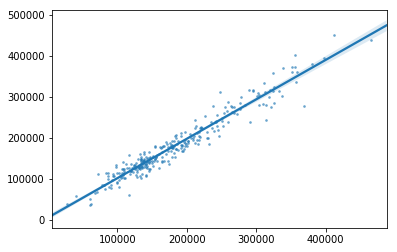

In [31]:
# Creating a scatter plot of the above results:
ax = sns.regplot(x=y_pred, y=y_test,
                 scatter_kws={"marker": "D", # Set marker style
                        "alpha": .5,
                        "s": 3})
# Perfect world is a straight line.
# Not too bad. Definitely room for improvement!

### 4.2 Model 2: Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=0)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

log_error = rmsle(y_test, y_pred)
print(log_error)

y_pred_rf = y_pred

# Not the best score...

0.13780626403217083


### 4.3 Model 3: Kernel Ridge

In [34]:
from sklearn.kernel_ridge import KernelRidge

KRR = KernelRidge(alpha=1000000, kernel='polynomial', degree=2, coef0=2.5)
KRR.fit(X_train,y_train)

y_pred = KRR.predict(X_test)
y_pred_krr = y_pred

log_error = rmsle(y_test, y_pred)
print(log_error)

# Alpha higher than this leads to worse score...

0.14219913601663517


### Model 4: XGBoost

In [35]:
import xgboost as xgb
xgboost = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

xgboost.fit(X_train,y_train)

y_pred = xgboost.predict(X_test)
y_pred_xgb = y_pred

log_error = rmsle(y_test, y_pred)
print(log_error)

0.12055122708497598


### 4.4 Model 5: Neural Net

#### 4.4.1 Preprocessing

In [137]:
# Double checking for types and number of NaNs
# house_test_d.columns.to_series().groupby(house_train_d.dtypes).groups
# house_test_d.isnull().sum().sum()

In [54]:
import warnings
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

train = house_train_d.ix[:,0:265]
test = house_test_d

col_train = list(train.columns)
col_train_bis = list(train.columns)

#col_train_bis.remove('SalePrice')


mat_train = np.matrix(train) # matrix from train (1456 rows)
mat_test  = np.matrix(test)  # matrix from test( ~1456 rows)
# mat_new = np.matrix(train.drop('SalePrice',axis = 1))  # mat_train but removing sale price
# mat_y = np.array(train.SalePrice).reshape((1456,1))   # just sale price

# Scaling mat_y
#prepro_y = MinMaxScaler()
#prepro_y.fit(mat_y)

# Scaling mat_test
prepro_test = MinMaxScaler()
prepro_test.fit(mat_test)

# Scaling mat_train
prepro = MinMaxScaler()
mat_train_part = mat_train[:,0:265]
prepro.fit(mat_train_part)

# Scaling mat_new
#prepro_test = MinMaxScaler()
#prepro_test.fit(mat_new)

train = pd.DataFrame(prepro.transform(mat_train_part),columns = col_train)

train.assign(SalePrice = house_train['SalePrice'], inplace = True)
l1 = list(house_train_d['SalePrice'])
train['SalePrice'] = l1

test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

print(train.shape)
print(test.shape)
train.head()

(1456, 266)
(1459, 265)


,1stFlrSF,2ndFlrSF,3SsnPorch,Age,BadHeating,Bedroom,BoughtOffPlan,BsmtCond,BsmtExposure,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,SalePrice
0,0.180373,0.413559,0.0,0.050725,0.0,0.375,0.0,0.75,0.000000,0.322669,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,208500.0
1,0.320663,0.000000,0.0,0.246377,0.0,0.375,0.0,0.75,1.000000,0.446984,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,181500.0
2,0.202488,0.419370,0.0,0.065217,0.0,0.375,0.0,0.75,0.333333,0.222121,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,223500.0
3,0.216655,0.366102,0.0,0.688406,0.0,0.375,0.0,1.00,0.000000,0.098720,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,140000.0
4,0.280235,0.509927,0.0,0.072464,0.0,0.500,0.0,0.75,0.666667,0.299360,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,250000.0


### 4.4.2 Setup (cont.) and Training/Testing

In [57]:
# List of features
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "SalePrice"

# Columns for tensorflow
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS]
prediction_set = train.SalePrice

#print(training_set.shape)
#print(prediction_set)

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)
training_set.head()

# Training for submission
training_sub = training_set[col_train]

In [58]:
# Same thing but for the test set
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)
testing_set.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Age,BadHeating,Bedroom,BoughtOffPlan,BsmtCond,BsmtExposure,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,SalePrice
497,0.276088,0.332688,0.0,0.615942,0.0,0.500,0.0,0.75,0.000000,0.150366,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,184000.0
1261,0.266068,0.331235,0.0,0.384058,0.0,0.625,0.0,0.75,0.666667,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,161500.0
411,0.249482,0.000000,0.0,0.398551,0.0,0.375,0.0,0.75,0.333333,0.482633,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,145000.0
1046,0.226676,0.000000,0.0,0.115942,0.0,0.375,0.0,0.75,0.000000,0.313528,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,145000.0
1033,0.214236,0.000000,0.0,0.521739,0.0,0.250,0.0,0.50,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,119750.0


In [59]:
# Reset the index of training
training_set.reset_index(drop = True, inplace =True)

In [60]:
def input_fn(data_set, pred = False):
    
    if pred == False:
        
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        labels = tf.constant(data_set[LABEL].values)
        
        return feature_cols, labels

    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        
        return feature_cols

In [61]:
# print(COLUMNS)

In [62]:
import tensorflow as tf
tf.Session()

# Model
tf.logging.set_verbosity(tf.logging.ERROR)
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, 
                                          hidden_units=[200,100,50,25,12])#, #100 removed                              
                                          #optimizer = tf.train.GradientDescentOptimizer( learning_rate= 0.1 ))
                                          #optimizer = tf.train.AdamOptimizer(learning_rate=.1))
training_set.reset_index(drop = True, inplace =True)

In [65]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=4000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x1a2f4785f8>, 'hidden_units': [200, 100, 50, 25, 12], 'feature_columns': (_RealValuedColumn(column_name='1stFlrSF', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='2ndFlrSF', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='3SsnPorch', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Age', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BadHeating', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Bedroom', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BoughtOffPlan', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BsmtC

In [66]:
# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)
print(ev)

{'loss': 795956200.0, 'global_step': 4000}


In [73]:
# Display the score on the testing set
# 0.002X in average
loss_score1 = ev["loss"]
#print("Final Loss on the testing set: {0:f}".format(loss_score1))

# Predictions
y_pred = np.array(list(regressor.predict(input_fn=lambda: input_fn(testing_set))))
y_pred_nn = y_pred
# predictions = list(itertools.islice(y, testing_set.shape[0]))
y_test = np.array(testing_set['SalePrice'])

log_error = rmsle(y_test, y_pred)
print(log_error)

(481,)
(481,)
0.13633003789967857


### 4.6 More Complex Sklearn Models (Work in progress)

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
# import xgboost as xgb
# import lightgbm as lgb

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = np.sqrt(-cross_val_score(model, train, target, scoring="neg_mean_squared_error", cv=cv))
    return score

#Models:
# lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

# ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

# KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

# GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
#                                    max_depth=4, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10, 
#                                    loss='huber', random_state =5)

# model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=720,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

# score = rmsle_cv(lasso)
# print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

## 5. Ensembling

In [90]:
# Bring results together...
# y_pred_lasso
# y_pred_krr
# y_pred_rf
# y_pred_xgb
# y_pred_nn
print(y_pred_lasso.shape)
print(y_pred_rf.shape)
print(y_pred_krr.shape)
print(y_pred_xgb.shape)
y_pred = np.column_stack((y_pred_lasso, y_pred_rf, y_pred_krr, y_pred_xgb))
y_pred = np.mean(y_pred, axis = 1)
#y_pred = np.concatenate(y_pred_lasso, y_pred_rf, axis = 1)

log_error = rmsle(y_test, y_pred)
print(log_error)

# Note the good score...


(292,)
(292,)
(292,)
(292,)
0.11577818300853986


## 6. Write to CSV (results, data, etc)

In [ ]:
# Here we are writing our cleaned dataframe to a CSV...

In [ ]:
house_train_d.to_csv("train_dummies.csv")
house_test_d.to_csv("test_dummies.csv")